<a href="https://colab.research.google.com/github/avril-rdgz/SCEDS_TVMA/blob/naima_branch/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I. Code replication

Packages and data load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

url="https://raw.githubusercontent.com/avril-rdgz/SCEDS_TVMA/refs/heads/main/predictors_data.csv"
df = pd.read_csv(url)
df.head()

,CRSP_SPvwx,DFY,tbl,ntis,TMS,log_DP,log_EP,lty,bm,infl,log_DY,log_DE,svar,ltr,DFR
0,-0.012417,0.0060,0.0038,0.050864,0.0175,-3.047824,-2.480303,0.0213,0.741535,0.019952,-3.056357,-0.567521,0.005718,0.003502,0.004205
1,-0.002561,0.0066,0.0038,0.046888,0.0178,-2.996390,-2.357310,0.0216,0.741117,0.004533,-2.993757,-0.639080,0.006663,0.000587,0.003818
2,-0.005630,0.0062,0.0080,0.044030,0.0133,-2.951079,-2.277102,0.0213,0.740323,0.043557,-2.957675,-0.673977,0.004086,0.009987,-0.028135
3,0.014253,0.0066,0.0095,0.029166,0.0148,-2.902206,-2.251619,0.0243,0.725326,0.018767,-2.889710,-0.650588,0.002356,-0.039832,0.022582
4,-0.014373,0.0070,0.0100,0.027165,0.0141,-2.875888,-2.176876,0.0241,0.841422,-0.000104,-2.890372,-0.699012,0.004842,0.010032,0.007850


Model

In [2]:
def DGP(T, J, R2, alpha=1.5):
    c = np.sqrt(R2 / (1 - R2))

    t = np.arange(1, T + 1)
    tau = t / T
    F_tau = tau**3

    X = np.zeros((T, J))
    X[:, 0] = 1
    X[:, 1:] = np.random.randn(T, J - 1)
    j = np.arange(1, J + 1)
    theta = c * np.sqrt(2) * j**(-(alpha + 0.5))

    mu = F_tau * (X @ theta)
    eps = np.random.randn(T)
    Y = mu + eps

    return Y, X, mu

Methodology: Estimator

c = 0.5: criterion fails at j = 45
c = 1.5: criterion fails at j = 70
c = 2.5: criterion fails at j = 85


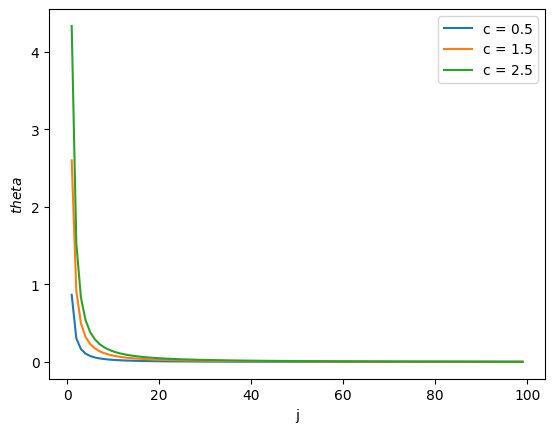

  0%|          | 0/9 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [3]:
def check_true_dgp():
    alpha = 1.5
    j = np.arange(1, 100)
    cs = [0.5, 1.5, 2.5]

    theta_prev = 0
    eps = 1e-4
    for c in cs:
        theta = c * np.sqrt(2 * alpha) * j**(-alpha)
        diffs = np.abs(np.diff(theta))
        if np.all(diffs > eps):
            print(f"c = {c}: criterion satisfied for all j")
        else:
            first_fail = np.where(diffs <= eps)[0][0]
            print(f"c = {c}: criterion fails at j = {j[first_fail+1]}")

        plt.plot(j, theta, label=f"c = {c}")
    plt.xlabel("j")
    plt.ylabel("$theta$")
    plt.legend()
    plt.show()

def kernel_vec(t, T, h):
    u = (np.arange(T) - t) / (h * T)
    return np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0.0)   # Epanechnikov

def local_jackknife(Y, X, h):
    T = len(Y); mu_tilde = np.empty(T)
    for t in range(T):
        K = kernel_vec(t, T, h)           # K_t
        K[t] = 0.0                         # leave‑one‑out
        W = np.diag(K)
        beta = np.linalg.solve(X.T @ W @ X, X.T @ W @ Y)
        mu_tilde[t] = X[t, :] @ beta
    return mu_tilde

def obj_cv(w, mu_mat, Y, K):
    mu_w = mu_mat @ w
    resid = Y - mu_w
    return np.sum(resid * K * resid)

def tvjma(Y, X_list, h):
    T, M = len(Y), len(X_list)
    mu_mat = np.empty((T, M))
    for m, X in enumerate(X_list):
        mu_mat[:, m] = local_jackknife(Y, X, h)

    w_hat = np.zeros((T, M)); mu_hat = np.empty(T)
    for t in range(T):
        K = kernel_vec(t, T, h)
        K[t] = 0.0
        # use all rows of mu_mat because the CV loss uses the full sample
        cons = ({'type':'eq','fun':lambda w: np.sum(w)-1},
                {'type':'ineq','fun':lambda w: w})
        w0 = np.full(M, 1./M)
        res = minimize(obj_cv, w0, args=(mu_mat, Y, K),
                       method='SLSQP', constraints=cons,
                       options={'ftol':1e-9})
        w_hat[t] = res.x
        mu_hat[t] = mu_mat[t] @ w_hat[t]
    return mu_hat, w_hat

def build_X_list(X):
    T, J = X.shape
    X_list = []

    for m in range(1, J + 1):
        X_list.append(X[:, :m])

    return X_list

def monte_carlo(T, J, R2, n_rep=1000):
    h = 2.34 * T**(-0.5)
    mse = np.empty(n_rep)
    for r in tqdm(range(n_rep)):
        Y ,X, mu_true = DGP(T, 100, R2)
        X = X[:, :J      ]
        X_list = build_X_list(X)
        mu_hat, _ = tvjma(Y, X_list, h)
        mse[r] = (np.mean((mu_hat - mu_true)**2) / np.mean(mu_true**2))

    return mse.mean()


check_true_dgp()
R2_grid = np.arange(0.1, 1.0, 0.1)
rmse = np.zeros(len(R2_grid))
for i, R in enumerate(tqdm(R2_grid)):
  rmse[i] = monte_carlo(100, 15, R, n_rep=1000)

plt.plot(R2_grid, rmse, linewidth=2)
plt.xlabel(r"$R^2$")
plt.ylabel("Relative MSE")
plt.title("TVJMA (Jackknife), T=100")
plt.show()

Methodology: Comparison